In [1]:
import os
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.wrappers import FlattenObservation
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy

import torch
from torch import nn

NUM_INPUT_VALUES = 100
MAX_STEPS = 6

class MyObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(MyObservationWrapper, self).__init__(env)
        self.observation_space = spaces.MultiDiscrete([2 for _ in range(6)] + [NUM_INPUT_VALUES for _ in range(6)])
            
    def reverse_observation(self, observation):
        return {
            "points": observation[:7],
            "features": observation[7:]
        }
    
    def observation(self, observation):
        return np.concatenate((observation["points"], observation["features"]), axis=0)
    
class MyActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super(MyActionWrapper, self).__init__(env)
        self.action_space = spaces.MultiDiscrete([3, NUM_INPUT_VALUES])
        
    def action(self, action):
        #print("action:", action)
        #print("action.size()", len(action))
        return {
            "function": action[0],
            "input": action[1]
        }

    def reverse_action(self, action):
        return np.array([action["function"], action["input"]])
    
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


/Users/matus/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DummyContract:
    def __init__(self, features):
        self.points = [0 for i in range(6)] #coverage
        self.features = features
        
    def fn0(self, x):
        if x <= self.features[0]:
            self.points[0] = 1
        
        if x >= self.features[1]:
            self.points[1] = 1
    
    def fn1(self, x):
        if x <= self.features[2]:
            self.points[2] = 1
        
        if x >= self.features[3]:
            self.points[3] = 1
    
    def fn2(self, x):
        if x <= self.features[4]:
            self.points[4] = 1
        
        if x >= self.features[5]:
            self.points[5] = 1

class MyEnv(gym.Env):
    
    def __init__(self):
        super(MyEnv, self).__init__()
        self.contract = None
        self.num_steps = None
        
        self.observation_space = spaces.Dict({
            "points": spaces.MultiBinary(6), 
            "features": spaces.MultiDiscrete([NUM_INPUT_VALUES for _ in range(6)])
        })
        
        self.action_space = spaces.Dict({
            "function": spaces.Discrete(3), 
            "input": spaces.Discrete(10)
        })
        
    def reset(self):
        features = spaces.MultiDiscrete([NUM_INPUT_VALUES for _ in range(6)]).sample().tolist()
        self.contract = DummyContract(features)
        self.num_steps = 0
        
        observation = {
            "points": np.array(self.contract.points, dtype=np.int8), 
            "features": np.array(self.contract.features)
        }
        return observation
    
    def step(self, action):
        self.num_steps += 1
        fn_index, fn_input = action["function"], action["input"]
        
        prev_score = sum(self.contract.points)

        if fn_index == 0:
            self.contract.fn0(fn_input)
        
        elif fn_index == 1:
            self.contract.fn1(fn_input)
            
        elif fn_index == 2:
            self.contract.fn2(fn_input)
            
        score = sum(self.contract.points)
        reward = score - prev_score
        
        reward = -1 if reward == 0 else reward
        
        info = {}
        
        done = self.num_steps == MAX_STEPS or score == 6
        
        #observation = np.array(self.contract.points).astype(np.int8)
        observation = {
            "points": np.array(self.contract.points, dtype=np.int8), 
            "features": np.array(self.contract.features)
        }

        return observation, reward, done, info
        
    def render(self, mode='console'):        
        raise NotImplementedError()

    def close(self):
        pass

env = MyEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

/Users/matus/Documents/soroban/simple-contract-generator/baselines3/stable_baselines3/common/env_checker.py:81: UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
  warnings.warn(


In [3]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = MyActionWrapper(MyObservationWrapper(MyEnv()))
env = Monitor(env, log_dir)

model = PPO(MlpPolicy, env, verbose=0)

callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

In [4]:
model.policy.mlp_extractor

MlpExtractor(
  (shared_net): Sequential()
  (policy_net): Sequential(
    (0): Linear(in_features=612, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (value_net): Sequential(
    (0): Linear(in_features=612, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
)

In [5]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-3.34 +/- 1.60


In [6]:
model.learn(total_timesteps=100000, callback=callback)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 1.43
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 20000
Best mean reward: 1.43 - Last mean reward per episode: 2.18
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 30000
Best mean reward: 2.18 - Last mean reward per episode: 2.62
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 40000
Best mean reward: 2.62 - Last mean reward per episode: 2.64
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 50000
Best mean reward: 2.64 - Last mean reward per episode: 3.35
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 60000
Best mean reward: 3.35 - Last mean reward per episode: 3.11
Num timesteps: 70000
Best mean reward: 3.35 - Last mean reward per episode: 3.15
Num timesteps: 80000
Best mean reward: 3.35 - Last mean reward per episode: 3.31
Num timesteps: 90000
Best mean reward: 3.35 - Last mean reward per episode: 3.80
Saving new best model

In [7]:
# from pprint import pprint
# for i in range(100):
#     env = MyActionWrapper(MyObservationWrapper(MyEnv()))
#     obs = env.reset()
#     prints = []

#     for j in range(50):
#         action, _ = model.predict(obs)
#         obs, reward, done, info = env.step(action)
        
#         prints.append([action, obs, reward, done])
         
#         if done:
#             if j > 6:
#                 pprint(prints)
#             break

In [8]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1000)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:3.53 +/- 2.97


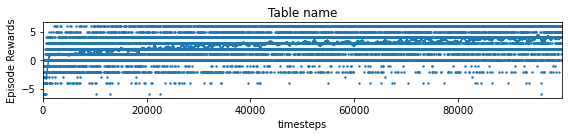

In [9]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Table name")

In [10]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

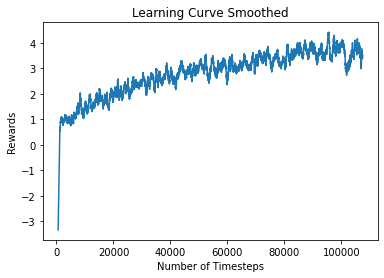

In [11]:
plot_results(log_dir)

In [11]:
env = MyActionWrapper(MyObservationWrapper(MyEnv()))
env.reset()

array([0, 0, 0, 0, 0, 0, 2, 9, 4, 2, 0, 4])

In [222]:
#env.step({"function": 2, "input": 8}), env.num_steps
env.step(np.array([2,4])), env.num_steps

observation


((array([0, 0, 0, 0, 1, 1, 3, 6, 2, 5, 7, 7]), 1, False, {}), 3)

In [13]:
env.observation_space

MultiDiscrete([ 2  2  2  2  2  2 10 10 10 10 10 10])

In [220]:
env.action_space

MultiDiscrete([ 3 10])

In [221]:
env.reverse_observation({
    'points': np.array([0, 0, 0, 0, 0, 0], dtype=np.int8),
    'features': np.array([3, 6, 2, 5, 7, 7])
})

reverse_observation


TypeError: unhashable type: 'slice'

In [38]:
spaces.MultiDiscrete([10 for _ in range(6)]).sample().tolist()

[7, 3, 8, 9, 9, 4]

In [10]:
spaces.MultiBinary(6).sample()

array([1, 0, 1, 1, 0, 1], dtype=int8)

In [19]:
e = MyEnv()
for k, v in e.action_space.items():
    print(k, v)

function Discrete(3)
input Discrete(10)


In [18]:
dir(e.action_space)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_np_random',
 '_shape',
 'contains',
 'dtype',
 'from_jsonable',
 'items',
 'keys',
 'np_random',
 'sample',
 'seed',
 'shape',
 'spaces',
 'to_jsonable',
 'values']

In [23]:
spaces.MultiDiscrete([[2,2], [10,10]]).sample()

array([[1, 0],
       [8, 6]])

In [15]:
isinstance("abc", str)

True

In [16]:
list("abc")

['a', 'b', 'c']

In [19]:
len("")

0

In [23]:
"".split(",")

['']

In [29]:
from datetime import datetime 
d = datetime(2012,4,1,0,0)
isinstance(d, list)

False

In [ ]:
d.timestamp()